<a href="https://colab.research.google.com/github/oughtinc/ergo/blob/notebooks-readme/assorted-predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
!pip install --quiet poetry  # Fixes https://github.com/python-poetry/poetry/issues/532
!pip install --quiet git+https://github.com/oughtinc/ergo.git@submit_mixture
!pip install --quiet pendulum seaborn requests
!pip install --quiet torch

     |████████████████████████████████| 225kB 2.8MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 112kB 9.0MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 92kB 6.6MB/s 
     |████████████████████████████████| 2.7MB 8.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 522kB 7.8MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 29.3MB 105kB/s 
     |████████████████████████████████| 153kB 41.5MB/s 
     |████████████████████████████████| 491kB 47.7MB/s 
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.


In [0]:
%load_ext google.colab.data_table

In [0]:
import ergo
import pendulum
import pandas
import seaborn
import requests
import re
import numpy as np
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Set up Metaculus API

In [0]:
metaculus = ergo.Metaculus(username="ought", password=passwords["ought"], api_domain="pandemic")
# metaculus = ergo.Metaculus(username="oughttest", password=passwords["oughttest"], api_domain="pandemic")

# Utils

In [0]:
def will_x_happen_prediction (model_uncertainty, start, p_at_start, end):
  start_to_end = (end - start).days
  days_remaining = (end - pendulum.now()).days
  proportion_time_remaining = days_remaining / start_to_end
  model_prediction = p_at_start * proportion_time_remaining

  return model_prediction + model_uncertainty

# should be 1
will_x_happen_prediction(0.5, pendulum.now(), 0.5, pendulum.datetime(2020,7,7))

1.0

# Questions

## JSON

In [0]:
question_infos = [
    {
        "name": "What will the Seattle Police Department report as the total number of criminal offenses in March 2020?",
        "id": 3924
    },
    {
        "name": "What will Washington state’s Department of Revenue report as the 2020 Q1 gross business income?",
        "id": 3923
    },
    {
        "name": "Will the US federal government shut down all non-essential services by 2020-04-19?",
        "id": 3921
    },
    {
        "name": "Will the Emergency Telework Act (S.3561) become law by 4/25/20?",
        "id": 3918
    },
    {
        "name": "By May 1 will there be an iOS or Android app that shares an individual's COVID-19 infection status with more than 1M other users?",
        "id": 3915
    },
    {
        "name": "By June 1, how many tests for COVID-19 will have been administered in the US?",
        "id": 3916
    },
    {
        "name": "[short fuse] How many total confirmed deaths of novel coronavirus will be reported in the state of New York by April 2nd?",
        "id": 3934
    },
    {
        "name": "What will be the US unemployment rate for March 2020?",
        "id": 3922
    },
    {
        "name": "How many days will the city of New Orleans spend under lockdown between 2020-03-25 and 2020-04-15?",
        "id": 3930
    },
    {
        "name": "Will Florida go under lockdown between 2020-03-25 and 2020-04-25?",
        "id": 3926
    }
]

## Dataframe

In [0]:
questions = [metaculus.get_question(question_info["id"], name=question_info["name"]) for question_info in question_infos]
ergo.MetaculusQuestion.to_dataframe(questions)

,id,name,title,resolve_time
0,3924,What will the Seattle Police Department report...,What will the Seattle Police Department report...,2020-04-26 06:59:00+00:00
1,3923,What will Washington state’s Department of Rev...,What will Washington state’s Department of Rev...,2020-04-26 06:59:00+00:00
2,3921,Will the US federal government shut down all n...,Will the US federal government shut down all n...,2020-04-19 06:59:00+00:00
3,3918,Will the Emergency Telework Act (S.3561) becom...,Will the Emergency Telework Act (S.3561) becom...,2020-04-26 06:59:00+00:00
4,3915,By May 1 will there be an iOS or Android app t...,By May 1 will there be an iOS or Android app t...,2020-05-01 07:00:00+00:00
5,3916,"By June 1, how many tests for COVID-19 will ha...","By June 1, how many tests for COVID-19 will ha...",2020-06-01 07:00:00+00:00
6,3934,[short fuse] How many total confirmed deaths o...,[short fuse] How many total confirmed deaths o...,2020-04-02 04:00:00+00:00
7,3922,What will be the US unemployment rate for Marc...,What will be the US unemployment rate for Marc...,2020-04-03 07:17:00+00:00
8,3930,How many days will the city of New Orleans spe...,How many days will the city of New Orleans spe...,2020-04-16 06:59:00+00:00
9,3926,Will Florida go under lockdown between 2020-03...,Will Florida go under lockdown between 2020-03...,2020-04-01 17:38:00+00:00


# Models

## 0. What will the Seattle Police Department report as the total number of criminal offenses in March 2020?

https://pandemic.metaculus.com/questions/3924/what-will-the-seattle-police-department-report-as-the-total-number-of-criminal-offenses-in-march-2020/

In [0]:
def crime_model():
  feb_total = 5090 # https://www.seattle.gov/police/information-and-data/crime-dashboard
  mar_difference_multiplier = ergo.lognormal_from_interval(0.3, 2)
  prediction = feb_total * mar_difference_multiplier
  ergo.tag(prediction, "mar_total")

crime_samples = ergo.run(crime_model, 1000)

questions[0].samples = crime_samples.mar_total

# questions[0].show_submission(questions[0].samples)

100%|██████████| 1000/1000 [00:00<00:00, 2322.84it/s]


#### Apr 4
* We're already predicting a broader range than the community on this one, and our median is close to the community median. I don't see any obvious reason to change anything
* TODO:
  * This one is ripe for reference-class comparison, which I haven't done at all:
    * what does data from other states, or early data from WA, show re: impact of coronavirus on crime?
    * what impact did other catastophes have on crime in the past?

### 1. What will Washington state’s Department of Revenue report as the 2020 Q1 gross business income?

https://pandemic.metaculus.com/questions/3923/what-will-washington-states-department-of-revenue-report-as-the-2020-q1-gross-business-income/

In [0]:
wa_df = pandas.read_csv("https://gist.githubusercontent.com/brachbach/5dc01125a44ce28e067a2dddb18f8a02/raw/12b16deecef9848c1f75432cf9aca5b61b1fd26a/WAGrossBusiness.csv")
wa_df["Total Gross"] = wa_df["Total Gross"].apply(lambda x: int(re.sub('[\$,]', '', x)))
wa_df["year"] = wa_df["Year"].apply(lambda x: int(x.split()[0]))
quarters = wa_df[wa_df["Year"].str.contains("Quarter")]
recent = quarters[quarters["year"] >= 2017]
recentish = quarters[quarters["year"] >= 2008]
worst_quarters = recentish.nsmallest(10, "Total Gross")

In [0]:
recentish

,Year,NAICS,Total Gross,Units,year
0,2019 Quarter 3,All NAICS,237687289560,"246,154",2019
1,2019 Quarter 2,All NAICS,235895076961,"244,453",2019
2,2019 Quarter 1,All NAICS,217177570561,"234,591",2019
3,2018 Quarter 4,All NAICS,257804331180,"352,024",2018
4,2018 Quarter 3,All NAICS,236068790931,"233,228",2018
5,2018 Quarter 2,All NAICS,219719073510,"228,626",2018
6,2018 Quarter 1,All NAICS,203079048068,"221,748",2018
8,2017 Quarter 4,All NAICS,227663229937,"351,078",2017
9,2017 Quarter 3,All NAICS,210867803892,"229,472",2017
10,2017 Quarter 2,All NAICS,204263367379,"226,214",2017


In [0]:
worst_quarters

,Year,NAICS,Total Gross,Units,year
51,2009 Quarter 1,All NAICS,127874475307,"180,577",2009
46,2010 Quarter 1,All NAICS,132621379249,"181,869",2010
50,2009 Quarter 2,All NAICS,133652503413,"184,713",2009
49,2009 Quarter 3,All NAICS,138473535728,"185,643",2009
45,2010 Quarter 2,All NAICS,139269736881,"186,512",2010
41,2011 Quarter 1,All NAICS,142981766513,"187,160",2011
56,2008 Quarter 1,All NAICS,145982311778,"185,348",2008
36,2012 Quarter 1,All NAICS,146762378611,"190,344",2012
44,2010 Quarter 3,All NAICS,147264405798,"187,064",2010
40,2011 Quarter 2,All NAICS,151713565602,"191,159",2011


In [0]:
def wa_rev_model():
  proxy_gross = ergo.random_choice(recent["Total Gross"].to_list())
  # fuzzed to be more likely to be worse than normal rather than better
  fuzzed = ergo.normal_from_interval(proxy_gross * 0.5, proxy_gross * 1.2)
  ergo.tag(fuzzed, "mar_gross")

wa_rev_samples = ergo.run(wa_rev_model, 1000)

questions[1].samples = wa_rev_samples.mar_gross

# questions[1].show_submission(questions[1].samples)

100%|██████████| 1000/1000 [00:00<00:00, 1808.48it/s]


* IMO our prediction is grossly overconfident
  * why do I think so:
    * much more confident than the community
    * my dumb model can't provide that much certainty
    * I think that the prediction for how things would go in the absence of coronavirus should be relatively close to the 90th percentile of our estimate, which it is not
  * TODO:
    * I think for now, just increase the fuzz factor
* The model predicts that revenue will turn out to have been much lower than expected for Q1 2020. It's not obvious why that'd be true
  * stay-at-home order was not issued until 23 Mar, i.e. almost the end of the quarter
  * TODO:
    * switch to basically assuing that Q1 2020 will be a normal quarter, not an abnormally bad one
    * figure out what my view on this should really be:
      * what exactly is "gross business income"?
      * how much should we expect it to have been hurt by corona before stay-at-home order?

### 2. Will the US federal government shut down all non-essential services by 2020-04-19?

https://pandemic.metaculus.com/questions/3921/will-the-us-federal-government-shut-down-all-non-essential-services-by-2020-04-19/

#### Thinking about the question

- As far as what people usually think of as "government shutdowns", seems like all have been caused by budgetary brinksmanship: https://www.thebalance.com/government-shutdown-3305683

- Seems like no budget showdowns coming up before the question expires: http://www.crfb.org/blogs/upcoming-congressional-fiscal-policy-deadlines

- So really we're just talking about coronavirus

- I feel like this might resolve ambiguously: "The president or other federal official formally announces a government shutdown"

- Also it's unclear whether no work _with pay_ would count as a "furlough" or not , per: "And / or at least 200,000 federal employees are furloughed for at least 1 week"

- Not much on Google about this possibility: https://www.google.com/search?q=us+federal+government+shutdown+coronavirus&tbm=nws

- Also not much about state shutdowns/furloughs

- So I think this is pretty unlikely, predicting 15%

In [0]:
shutdown_prediction = will_x_happen_prediction(0.05, pendulum.datetime(2020,4,4), 0.08, pendulum.datetime(2020,4,19))

questions[2].binary_prediction = shutdown_prediction

In [0]:
shutdown_prediction

0.07133333333333333

#### Apr 4
* Now several days later, not seeing any signs of this becoming more likely
  * so we should lower p
  * ~~write some simple code to do this automatically going forward~~

### 3. Will the Emergency Telework Act (S.3561) become law by 4/25/20?

https://pandemic.metaculus.com/questions/3918/will-the-emergency-telework-act-s3561-become-law-by-42520/

#### Thinking about the question

- looking at the question and the current comment, it seems like the thing to do is to model the procedure of bills becoming laws and then use that model to predict whether this one will
  - the first step is to build/find a qualitative model of the steps from bill to law
  - As the comment points out, it might require something really unusual for this to become law given that Congress is currently out of session, should look into that first
- What do I find from a quick Google News search on this? 
  - nothing from less than a week ago: https://www.google.com/search?q=Emergency+Telework+Act&source=lnms&tbm=nws

##### Qualitative model of bill to law

[This](https://www.zerotothree.org/resources/728-how-a-bill-becomes-a-law) seems like a good overall summary

And [this](https://www.usa.gov/how-laws-are-made) seems to have similar content

1.   Various things happen that we don't care about because they already happened for this bill, then: the bill gets introduced into the Senate and referred to a committee: ["Read twice and referred to the Committee on Homeland Security and Governmental Affairs."](https://www.congress.gov/bill/116th-congress/senate-bill/3561/all-actions?overview=closed&KWICView=false)
2. Committee delegates to subcommittee or submits to floor
3. debate on floor
4. votes in full House and Senate (by this point there may be separate bills in the Senate and House; not sure how likely that is for this bill, vs. just having one version
5. conference committee between House and Senate
6. full House and Senate agree to the version that came out of conference committee
7. President signs

##### Prediction
On further reflection, just seems unlikely to me that this will become law by the specified date given that it doesn't seem to have moved forward in the last week. Assigning 15% probability for now, may go back and build the model later


In [0]:
telework_prediction = will_x_happen_prediction(0.05, pendulum.datetime(2020,4,4), 0.08, pendulum.datetime(2020,4,25))

questions[3].binary_prediction = telework_prediction

telework_prediction

0.08809523809523809

#### Apr 4
* any new news on this?
  * no
  * so that's a slight further negative update, I'll move us down from 0.15 to 0.13
* TODO:
  * reference class forecasting. What's the right reference class of bills? How likely are they to become law? How long does it take them to become law?
    * use this to build a model of the progress of the Emergency Telework Act towards becoming law, use that model to estimate p(becomes law) by 25 Apr

###	4. By May 1 will there be an iOS or Android app that shares an individual's COVID-19 infection status with more than 1M other users?

https://pandemic.metaculus.com/questions/3915/by-may-1-will-there-be-an-ios-or-android-app-that-shares-an-individuals-covid-19-infection-status-with-more-than-1m-other-users/

#### Thinking about the question
* Seems really hard to think about
* Some related stuff:
  * Apple has a coronavirus screening app: https://www.apple.com/covid19/ (does not seem to share your status)
  * A friend of mine who values digital privacy but also other things posted on FB: "Question: Under current employment law, what are the rules about whether you can require seeing the results of a medical test before hiring someone?". This suggests to me that people would likely be open to an app like this, despite the sort of panoptic weirdness of it
  * China:
    * https://www.nytimes.com/2020/03/01/business/china-coronavirus-surveillance.html
      * app assigns you a coronavirus risk assessment that's sent to the government
      * doesn't report this to other users, so doesn't count
  * Should look into what dating apps are doing/considering
    * [didn't find too much](https://www.google.com/search?q=dating+app+share+coronavirus+status&source=lnms&sa=X&ved=0ahUKEwjZyIv9-MXoAhWYJzQIHYx-DGEQ_AUIDSgA&biw=1200&bih=1809&dpr=1)
  * Seems likely that the app would star=t somewhere other than the US. East Asia seems particularly likely
* One way to make a breakthrough on this question would be to learn about an app/feature that's in development
* thinking about reference class, or at least just similar things -- what sort of info about themselves do users share with each other in this way?
  * current prediction: 55%. Would have been at like 70% but surprised that we haven't already seen this come out of East Aia
  * Can you report HIV or other STI status:
    * on Grindr:
      * [Yes](https://www.npr.org/sections/thetwo-way/2018/04/03/599069424/grindr-admits-it-shared-hiv-status-of-users)
      * not sure about other STIs
    * on Fetlife?
      * seems like no, but that you also can't enter much other info for your profile
    * on Tinder? 
      * No
  * on OKCupid, you can answer a question about how you're feeling about coronavirus



In [0]:
app_prediction = will_x_happen_prediction(0.05, pendulum.datetime(2020,4,5), 0.55, pendulum.datetime(2020,5,1))

questions[4].binary_prediction = app_prediction

app_prediction

0.38846153846153847

#### 4 Apr update notes
* checked the comments, nothing new + interesting
* added in the consideration that you can answer on OKC re: how you're feeling about Coronavirus, which increased my p to 0.6

### 5. By June 1, how many tests for COVID-19 will have been administered in the US?	

https://pandemic.metaculus.com/questions/3916/by-june-1-how-many-tests-for-covid-19-will-have-been-administered-in-the-us/

Metaculus says that this is the best data source, seems reasonable: https://covidtracking.com/api/us/daily

In [0]:
daily_corona = pandas.read_csv("https://covidtracking.com/api/us/daily.csv")
daily_corona["date"] = daily_corona["date"].apply(lambda x: pendulum.parse(str(x)))
daily_corona = daily_corona.sort_values("date")

In [0]:
daily_corona

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
46,2020-02-28 00:00:00+00:00,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7de1cbe8b7b0a50a3afdd4b9c4d69ff78318681e,2020-02-28T21:00:00Z,4,NaN,9,9,9,NaN,NaN,NaN,NaN,NaN
45,2020-02-29 00:00:00+00:00,1,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243260e18d47e670dade08ee5a5195fcc8b5a9db,2020-02-29T21:00:00Z,5,NaN,18,18,18,1.0,0.0,0.0,9.0,9.0
44,2020-03-01 00:00:00+00:00,3,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ca260a1247d2b0574d24373499373db27272de6e,2020-03-01T21:00:00Z,8,NaN,40,40,40,3.0,0.0,0.0,22.0,22.0
43,2020-03-02 00:00:00+00:00,3,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6513d03460ba39e3593914dcf26e9686a6102c3a,2020-03-02T21:00:00Z,11,NaN,53,53,53,3.0,0.0,0.0,13.0,13.0
42,2020-03-03 00:00:00+00:00,3,94,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86770db4d6896557717aeae87fff9e3b90548964,2020-03-03T21:00:00Z,14,NaN,100,100,100,3.0,0.0,6.0,41.0,47.0
41,2020-03-04 00:00:00+00:00,16,209,759.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469fa0e70ed7d25e9989fc688df5f75ebb22cb54,2020-03-04T21:00:00Z,16,NaN,1071,968,968,2.0,0.0,753.0,115.0,868.0
40,2020-03-05 00:00:00+00:00,25,276,970.0,197.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06a56b8475204684dd5e5f5cf8290efe82eac39c,2020-03-05T21:00:00Z,20,NaN,1443,1246,1246,4.0,0.0,211.0,67.0,278.0
39,2020-03-06 00:00:00+00:00,37,394,1588.0,458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ea667c1aa458c1f53bedad18a3829e12319ec4fe,2020-03-06T21:00:00Z,26,NaN,2440,1982,1982,6.0,0.0,618.0,118.0,736.0
38,2020-03-07 00:00:00+00:00,51,550,1839.0,602.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6d22e33c87ce6d5ec8869e1cc5fefb61b3b2263c,2020-03-07T21:00:00Z,27,NaN,2991,2389,2389,1.0,0.0,251.0,156.0,407.0
37,2020-03-08 00:00:00+00:00,51,731,2335.0,347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b824c409750148b3d403801cce72744e637f8611,2020-03-08T20:00:00Z,31,NaN,3413,3066,3066,4.0,0.0,496.0,181.0,677.0


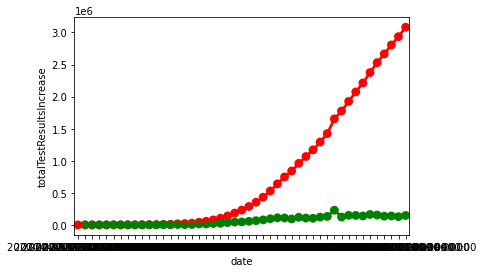

In [0]:
seaborn.pointplot(daily_corona["date"], daily_corona["totalTestResults"], color="red")
seaborn.pointplot(daily_corona["date"], daily_corona["totalTestResultsIncrease"], color="green")

Original notes: Looks like there have been a constant number of new tests per day lately, so just assume that will continue to be the case

In [0]:
def tests_model():
    latest_date = pendulum.instance(daily_corona.iloc[-1]["date"])
    total_tests = daily_corona.iloc[-1]["totalTestResults"]
    last_five_days = daily_corona.nlargest(5,"date")
    avg_recent_daily_tests = last_five_days["totalTestResultsIncrease"].mean()

    tests_per_day_high = ergo.normal_from_interval(avg_recent_daily_tests * 1, avg_recent_daily_tests * 10)
    tests_per_day_likely = ergo.lognormal_from_interval(avg_recent_daily_tests * 0.2, avg_recent_daily_tests * 2)
    tests_per_day = ergo.random_choice([tests_per_day_high, tests_per_day_likely, tests_per_day_likely, tests_per_day_likely])
    end_date = pendulum.date(2020,6,1)
    for i in range((end_date - latest_date).days + 1):
      date = latest_date.add(days=i)
      total_tests = total_tests + tests_per_day
      ergo.tag(total_tests, date.format('YYYY/MM/DD'))

test_samples = ergo.run(tests_model, 1000)

questions[5].samples = test_samples["2020/06/01"]

# questions[5].show_submission(questions[5].samples)
    

100%|██████████| 1000/1000 [00:10<00:00, 91.44it/s]


In [0]:
test_samples

,2020/04/14,2020/04/15,2020/04/16,2020/04/17,2020/04/18,2020/04/19,2020/04/20,2020/04/21,2020/04/22,2020/04/23,2020/04/24,2020/04/25,2020/04/26,2020/04/27,2020/04/28,2020/04/29,2020/04/30,2020/05/01,2020/05/02,2020/05/03,2020/05/04,2020/05/05,2020/05/06,2020/05/07,2020/05/08,2020/05/09,2020/05/10,2020/05/11,2020/05/12,2020/05/13,2020/05/14,2020/05/15,2020/05/16,2020/05/17,2020/05/18,2020/05/19,2020/05/20,2020/05/21,2020/05/22,2020/05/23,2020/05/24,2020/05/25,2020/05/26,2020/05/27,2020/05/28,2020/05/29,2020/05/30,2020/05/31,2020/06/01
0,3109747.50,3137875.0,3166002.50,3194130.0,3222257.50,3250385.0,3278512.50,3306640.0,3334767.50,3362895.0,3391022.50,3419150.0,3447277.50,3475405.0,3503532.50,3531660.0,3559787.50,3587915.0,3616042.50,3644170.0,3672297.50,3700425.0,3728552.50,3756680.0,3784807.50,3812935.0,3841062.50,3869190.0,3897317.50,3925445.0,3953572.50,3981700.0,4009827.50,4037955.0,4066082.50,4094210.0,4122337.5,4150465.0,4178592.5,4206720.0,4234847.5,4262975.0,4291102.5,4319230.0,4347357.5,4375485.0,4403612.5,4431740.0,4459867.5
1,3113232.75,3144845.5,3176458.25,3208071.0,3239683.75,3271296.5,3302909.25,3334522.0,3366134.75,3397747.5,3429360.25,3460973.0,3492585.75,3524198.5,3555811.25,3587424.0,3619036.75,3650649.5,3682262.25,3713875.0,3745487.75,3777100.5,3808713.25,3840326.0,3871938.75,3903551.5,3935164.25,3966777.0,3998389.75,4030002.5,4061615.25,4093228.0,4124840.75,4156453.5,4188066.25,4219679.0,4251291.5,4282904.0,4314516.5,4346129.0,4377741.5,4409354.0,4440966.5,4472579.0,4504191.5,4535804.0,4567416.5,4599029.0,4630641.5
2,3157299.50,3232979.0,3308658.50,3384338.0,3460017.50,3535697.0,3611376.50,3687056.0,3762735.50,3838415.0,3914094.50,3989774.0,4065453.50,4141133.0,4216812.50,4292492.0,4368171.50,4443851.0,4519530.50,4595210.0,4670889.50,4746569.0,4822248.50,4897928.0,4973607.50,5049287.0,5124966.50,5200646.0,5276325.50,5352005.0,5427684.50,5503364.0,5579043.50,5654723.0,5730402.50,5806082.0,5881761.5,5957441.0,6033120.5,6108800.0,6184479.5,6260159.0,6335838.5,6411518.0,6487197.5,6562877.0,6638556.5,6714236.0,6789915.5
3,3484130.25,3886640.5,4289151.00,4691661.5,5094172.00,5496682.5,5899193.00,6301703.5,6704214.00,7106724.5,7509235.00,7911745.5,8314256.00,8716766.0,9119276.00,9521786.0,9924296.00,10326806.0,10729316.00,11131826.0,11534336.00,11936846.0,12339356.00,12741866.0,13144376.00,13546886.0,13949396.00,14351906.0,14754416.00,15156926.0,15559436.00,15961946.0,16364456.00,16766966.0,17169476.00,17571986.0,17974496.0,18377006.0,18779516.0,19182026.0,19584536.0,19987046.0,20389556.0,20792066.0,21194576.0,21597086.0,21999596.0,22402106.0,22804616.0
4,3267345.75,3453071.5,3638797.25,3824523.0,4010248.75,4195974.5,4381700.50,4567426.5,4753152.50,4938878.5,5124604.50,5310330.5,5496056.50,5681782.5,5867508.50,6053234.5,6238960.50,6424686.5,6610412.50,6796138.5,6981864.50,7167590.5,7353316.50,7539042.5,7724768.50,7910494.5,8096220.50,8281946.5,8467672.00,8653398.0,8839124.00,9024850.0,9210576.00,9396302.0,9582028.00,9767754.0,9953480.0,10139206.0,10324932.0,10510658.0,10696384.0,10882110.0,11067836.0,11253562.0,11439288.0,11625014.0,11810740.0,11996466.0,12182192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3316038.50,3550457.0,3784875.50,4019294.0,4253712.50,4488131.0,4722549.50,4956968.0,5191386.50,5425805.0,5660223.50,5894642.0,6129060.50,6363479.0,6597897.50,6832316.0,7066734.50,7301153.0,7535571.50,7769990.0,8004408.50,8238827.0,8473246.00,8707665.0,8942084.00,9176503.0,9410922.00,9645341.0,9879760.00,10114179.0,10348598.00,10583017.0,10817436.00,11051855.0,11286274.00,11520693.0,11755112.0,11989531.0,12223950.0,12458369.0,12692788.0,12927207.0,13161626.0,13396045.0,13630464.0,13864883.0,14099302.0,14333721.0,14568140.0
996,3137795.50,3193971.0,3250146.50,3306322.0,3362497.50,3418673.0,3474848.50,3531024.0,3587199.50,3643375.0,3699550.50,3755726.0,3811

In [0]:
questions[5].submit_from_samples(test_samples["2020/06/01"])

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
  3%|▎         | 165/5000 [00:02<01:15, 64.43it/s]


Encoutered nan gradient, stopping early
[[        nan         nan -222.83087 ]
 [ 224.76326   261.89325   147.95656 ]
 [ 494.42953   993.1275     74.874306]]
[[ 0.517827    0.04312615 -2.975864  ]
 [ 0.68932223  0.24348636 -3.018332  ]
 [ 0.6501296   0.15358527 -3.0058026 ]]


<Response [202]>

#### Apr 4 updates
* ~~increase number of samples to run to 1000, 100 might have been too few~~
* My prediction distribution is way too narrow:
  * I think so because:
    * A priori -- there's no way I'm that confident
    * compared to the community prediction
  * What I'm going to do:
    * ~~instead of sampling tests_today every day, sample tests_per_day for the whole duration. I had already identified this as a way to make the model make more sense, and it will also lead to a wider distribution~~
    * TODO: do this in some more sophisticated way where I can more clearly express my guesses for how many tests will be administered over the whole interval, compared to now. Seems good to do, planning to come back to this
* tests per day looks slightly less constant now
  * TODO: consider modeling test_per_day based on something other than average tests over the past few days -- fit a quadratic or do a linear regression or something. Will skip this for now but maybe come back to it later


### 6. [short fuse] How many total confirmed deaths of novel coronavirus will be reported in the state of New York by April 2nd?

In [0]:
# from this metaculus comment: https://pandemic.metaculus.com/questions/3934/short-fuse-how-many-total-confirmed-deaths-of-novel-coronavirus-will-be-reported-in-the-state-of-new-york-by-april-2nd/#comment-25503
supposed_covid_timeseries = pandas.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
ny = supposed_covid_timeseries[supposed_covid_timeseries["state"].str.contains("New York")]

In [0]:
ny

,date,state,fips,cases,deaths
246,2020-03-01,New York,36,1,0
261,2020-03-02,New York,36,1,0
276,2020-03-03,New York,36,2,0
293,2020-03-04,New York,36,11,0
313,2020-03-05,New York,36,22,0
338,2020-03-06,New York,36,44,0
369,2020-03-07,New York,36,89,0
404,2020-03-08,New York,36,106,0
440,2020-03-09,New York,36,142,0
478,2020-03-10,New York,36,173,0


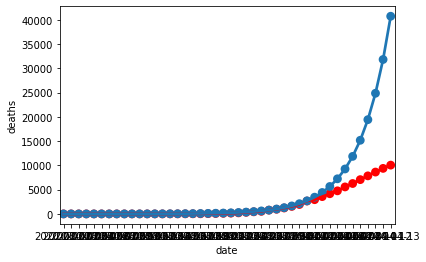

In [0]:
# manually fit an exponential curve
seaborn.pointplot(ny["date"], ny["deaths"], color="red")
seaborn.pointplot(ny["date"], [1.28**x for x in range(0,len(ny["date"]))])

In [0]:
def death_model():
  fit_base = 1.28
  # mar 29 is day 29, so apr 2 is day 33
  day_number = 33
  fuzzed_base = ergo.lognormal_from_interval(fit_base - 0.01, fit_base + 0.01)
  ergo.tag(fuzzed_base**day_number, "ny_deaths")

death_samples = ergo.run(death_model, 1000)

questions[6].samples = death_samples.ny_deaths
# questions[6].show_submission(questions[6].samples)

100%|██████████| 1000/1000 [00:00<00:00, 3019.83it/s]


### 7. What will be the US unemployment rate for March 2020?
https://pandemic.metaculus.com/questions/3922/what-will-be-the-us-unemployment-rate-for-march-2020/

In [0]:
monthly_unemployment_wide = pandas.read_csv("https://gist.githubusercontent.com/brachbach/d966ef4221215bdd58a5067802ded0be/raw/4a944a28eb9f222023396020913aabd507538060/monthly_unemployment_wide.csv")
# monthly_unemployment_wide

In [0]:
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
unemployment = pandas.melt(monthly_unemployment_wide, id_vars=["Year"],
                           value_vars=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
                           var_name="month",
                           value_name="percent_unemployment")

unemployment["month"] = unemployment["month"].apply(lambda name: months.index(name) + 1)
unemployment = unemployment.sort_values(by=["Year", "month"])
unemployment["monthly_diff"] = unemployment["percent_unemployment"].diff()
# unemployment

In [0]:
biggest_monthly_increase = unemployment.nlargest(5, "monthly_diff")
biggest_monthly_increase

,Year,month,percent_unemployment,monthly_diff
658,1949,10,7.9,1.3
808,1953,12,4.5,1.0
27,1975,1,8.1,0.9
293,1949,5,6.1,0.8
229,1958,4,7.4,0.7


In [0]:
def unemployment_model():
  proxy_delta = ergo.random_choice(biggest_monthly_increase["monthly_diff"].to_list())
  fuzzed_delta = ergo.normal_from_interval(proxy_delta * 0.5, proxy_delta * 2)
  feb_rate = 3.5
  ergo.tag(feb_rate + fuzzed_delta, "mar_unemployment")

unemployment_samples = ergo.run(unemployment_model, 1000)

questions[7].samples = unemployment_samples.mar_unemployment
# questions[7].show_submission(questions[7].samples)

100%|██████████| 1000/1000 [00:00<00:00, 1863.45it/s]


## 8. How many days will the city of New Orleans spend under lockdown between 2020-03-25 and 2020-04-15?

https://pandemic.metaculus.com/questions/3930/how-many-days-will-the-city-of-new-orleans-spend-under-lockdown-between-2020-03-25-and-2020-04-15/

Predicting in the [lockdown model](https://colab.research.google.com/drive/1BRplIkEvySIWLDfL2m-I2-69ES725Hnv)

## 9. Will Florida go under lockdown between 2020-03-25 and 2020-04-25?

https://pandemic.metaculus.com/questions/3926/will-florida-go-under-lockdown-between-2020-03-25-and-2020-04-25/

#### Thinking through the question
* Which other states are currently not under lockdown?
  * https://www.usatoday.com/story/news/nation/2020/03/21/coronavirus-lockdown-orders-shelter-place-stay-home-state-list/2891193001/
    * lists 34 states (`$('h2').length`)
  * https://www.wsj.com/articles/a-state-by-state-guide-to-coronavirus-lockdowns-11584749351
    * lists 31 states (`$("h6").length`), but actually Florida is on there so not all are true lockdowns
* Hmm, resolution may well be ambiguous. Florida is already doing some partial lockdown:
  * https://www.wsj.com/articles/florida-unlike-other-hard-hit-states-avoids-broad-coronavirus-lockdown-11585560601
  *[https://www.wsj.com/articles/a-state-by-state-guide-to-coronavirus-lockdowns-11584749351](reports that some parts of Florida have closed down business, but not all)
  * what if e.g. the Governor orders the businesses that ordinarily serve most Floridians to shut down, but doesn't close rural ones, and doesn't order people to stay home?

Doesn't seem crazy to me to think that the Governor will maintain the current not-quite a lockdown policy

In [0]:
questions[9].binary_prediction = 0.55

# Submit predictions

Convert samples to Metaculus distributions and visualize:

100%|██████████| 5000/5000 [00:18<00:00, 263.19it/s]


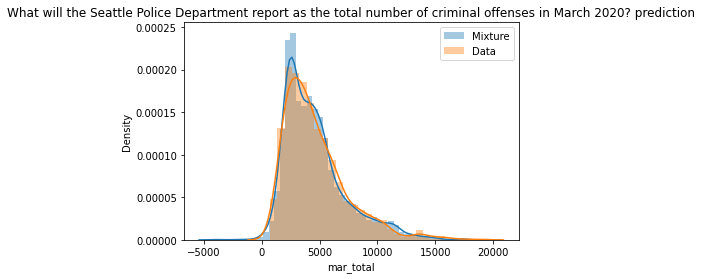

  1%|          | 26/5000 [00:00<00:19, 259.17it/s]

100%|██████████| 5000/5000 [00:18<00:00, 271.89it/s]


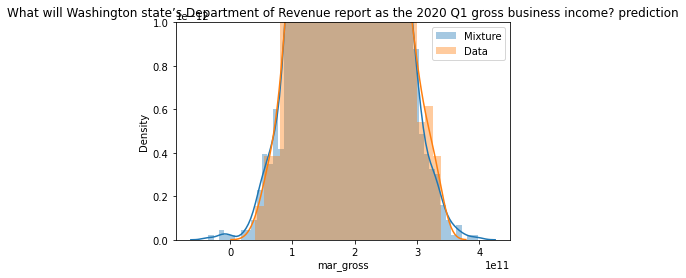

  0%|          | 25/5000 [00:00<00:20, 247.73it/s]







Prediction for Will the US federal government shut down all non-essential services by 2020-04-19?: 0.07133333333333333



Prediction for Will the Emergency Telework Act (S.3561) become law by 4/25/20?: 0.08809523809523809



Prediction for By May 1 will there be an iOS or Android app that shares an individual's COVID-19 infection status with more than 1M other users?: 0.38846153846153847





  3%|▎         | 166/5000 [00:00<00:19, 247.60it/s]


Encoutered nan gradient, stopping early
[[       nan        nan -229.19742]
 [ 281.74265  327.9386   125.21753]
 [ 427.8719   745.5885   103.97989]]
[[ 0.5213326   0.04481379 -2.9777741 ]
 [ 0.67209536  0.21730426 -3.0133    ]
 [ 0.6785902   0.17808057 -3.0089262 ]]


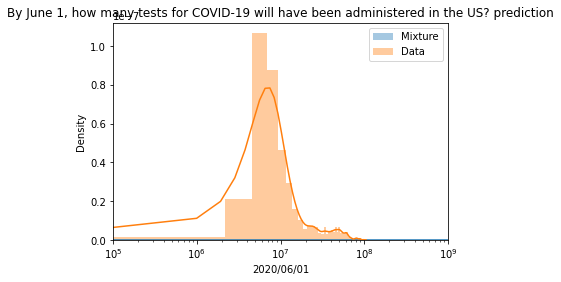

  1%|          | 28/5000 [00:00<00:17, 277.58it/s]

100%|██████████| 5000/5000 [00:18<00:00, 273.91it/s]


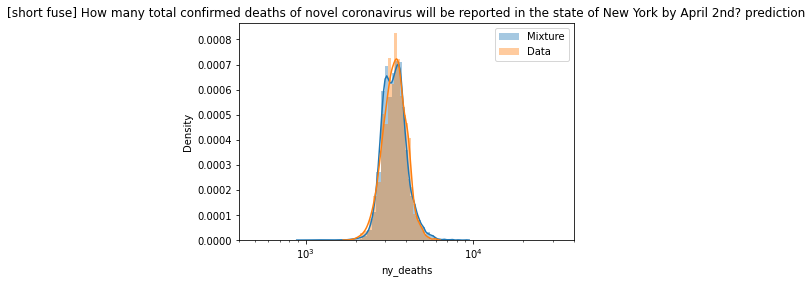

  0%|          | 24/5000 [00:00<00:20, 238.12it/s]

100%|██████████| 5000/5000 [00:18<00:00, 267.88it/s]


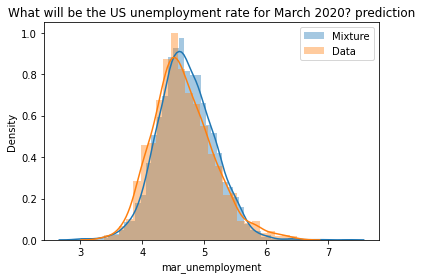







No submission or submission can't be shown for How many days will the city of New Orleans spend under lockdown between 2020-03-25 and 2020-04-15?






Prediction for Will Florida go under lockdown between 2020-03-25 and 2020-04-25?: 0.55





In [0]:
for question in questions:
  if question.type == "binary":
    print(f"Prediction for {question}: {question.binary_prediction}")
  elif question.type == "continuous":
    try:
      question.show_submission(question.samples)
    except:
      print(f"No submission or submission can't be shown for {question}")
    print("\n\n")
  else:
    raise ValueError("Unknown question type!")
  print("\n\n")

If everything looks good, submit the predictions!

In [0]:
def submit_all():
  for question in questions:
    if question.type == "binary":
      try:
        r = question.submit(question.binary_prediction)
        print(f"Submitted for {question.name}")
        print(f"https://pandemic.metaculus.com{question.page_url}")
      except requests.exceptions.HTTPError as e:
        print(f"Couldn't make prediction for {question.name} -- maybe this question is now closed? See error below.")
        print(e)
    elif question.type == "continuous":
      try:
        question.samples
      except:
        print(f"No predictions for {question}")
        continue

      try:
        r = question.submit_from_samples(question.samples)
        print(f"Submitted for {question.name}")
        print(f"https://pandemic.metaculus.com{question.page_url}")
      except requests.exceptions.HTTPError as e:
        print(f"Couldn't make prediction for {question.name} -- maybe this question is now closed? See error below.")
        print(e)
    else:
      raise ValueError("Unknown question type!")
      

submit_all()

  1%|          | 26/5000 [00:00<00:19, 255.36it/s]

Submitted for What will the Seattle Police Department report as the total number of criminal offenses in March 2020?
https://pandemic.metaculus.com/questions/3924/what-will-the-seattle-police-department-report-as-the-total-number-of-criminal-offenses-in-march-2020/


100%|██████████| 5000/5000 [00:18<00:00, 269.27it/s]


Submitted for What will Washington state’s Department of Revenue report as the 2020 Q1 gross business income?
https://pandemic.metaculus.com/questions/3923/what-will-washington-states-department-of-revenue-report-as-the-2020-q1-gross-business-income/
Couldn't make prediction for Will the US federal government shut down all non-essential services by 2020-04-19? -- maybe this question is now closed? See error below.
("('400 Client Error: Bad Request for url: https://pandemic.metaculus.com/api2/questions/3921/predict/',)", 'request body: {"prediction": 0.07133333333333333, "void": false}', 'response json: {\'non_field_errors\': ["Cannot predict on a question that\'s not open!"]}')
Submitted for Will the Emergency Telework Act (S.3561) become law by 4/25/20?
https://pandemic.metaculus.com/questions/3918/will-the-emergency-telework-act-s3561-become-law-by-42520/


  1%|          | 27/5000 [00:00<00:18, 264.02it/s]

Submitted for By May 1 will there be an iOS or Android app that shares an individual's COVID-19 infection status with more than 1M other users?
https://pandemic.metaculus.com/questions/3915/by-may-1-will-there-be-an-ios-or-android-app-that-shares-an-individuals-covid-19-infection-status-with-more-than-1m-other-users/


  3%|▎         | 134/5000 [00:00<00:19, 247.00it/s]


Encoutered nan gradient, stopping early
[[  56.726654  149.32896   200.03879 ]
 [        nan         nan -404.89557 ]
 [  48.187782  117.946884  204.85678 ]]
[[ 0.89044327  0.5763766  -3.0467222 ]
 [ 0.50971544  0.04337742 -2.8926947 ]
 [ 0.9081516   0.62669027 -3.0605824 ]]


  1%|          | 28/5000 [00:00<00:18, 273.43it/s]

Submitted for By June 1, how many tests for COVID-19 will have been administered in the US?
https://pandemic.metaculus.com/questions/3916/by-june-1-how-many-tests-for-covid-19-will-have-been-administered-in-the-us/


  0%|          | 23/5000 [00:00<00:21, 229.43it/s]

Couldn't make prediction for [short fuse] How many total confirmed deaths of novel coronavirus will be reported in the state of New York by April 2nd? -- maybe this question is now closed? See error below.
("('400 Client Error: Bad Request for url: https://pandemic.metaculus.com/api2/questions/3934/predict/',)", 'request body: {"prediction": {"kind": "multi", "d": [{"kind": "logistic", "x0": 0.5008589029312134, "s": 0.015188154764473438, "w": 0.19202777743339539, "low": 0.0, "high": 0.99}, {"kind": "logistic", "x0": 0.4805207848548889, "s": 0.016074342653155327, "w": 0.3177727460861206, "low": 0.0, "high": 0.99}, {"kind": "logistic", "x0": 0.45007002353668213, "s": 0.023274032399058342, "w": 0.490199476480484, "low": 0.0, "high": 0.99}]}, "void": false}', 'response json: {\'non_field_errors\': ["Cannot predict on a question that\'s not open!"]}')


100%|██████████| 5000/5000 [00:18<00:00, 266.35it/s]


Couldn't make prediction for What will be the US unemployment rate for March 2020? -- maybe this question is now closed? See error below.
("('400 Client Error: Bad Request for url: https://pandemic.metaculus.com/api2/questions/3922/predict/',)", 'request body: {"prediction": {"kind": "multi", "d": [{"kind": "logistic", "x0": 0.2211281955242157, "s": 0.01, "w": 0.7507925033569336, "low": 0.0, "high": 0.99}, {"kind": "logistic", "x0": 0.6863842010498047, "s": 0.4577600359916687, "w": 0.10677008330821991, "low": 0.0, "high": 0.6648781532403318}, {"kind": "logistic", "x0": 0.2636052072048187, "s": 0.012183872982859612, "w": 0.1424374282360077, "low": 0.0, "high": 0.99}]}, "void": false}', 'response json: {\'non_field_errors\': ["Cannot predict on a question that\'s not open!"]}')
No predictions for How many days will the city of New Orleans spend under lockdown between 2020-03-25 and 2020-04-15?
Couldn't make prediction for Will Florida go under lockdown between 2020-03-25 and 2020-04-25? 

# TODO
1. consider automatically pulling all open questions and matching them to models